## Multiple Schemas

Normally, all graph nodes communicate with a single schema.

Also, this single schema contains the graph's input and output keys / channels.

- Internal nodes may pass information that is not required in the graph's input / output.

- We may also want to use different input / output schemas for the graph. The output might, for example, only contain a single relevant output key.

## 1. Private State

- This can encapsulate the internal state not going to the input output in the graph that are not relevant to the input and output.


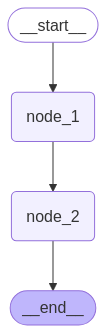

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

# make node to get the state overall state as input and update the internal state
# this return the internal state 
def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    print(state)
    # node should update the state 
    return {"baz": state['foo'] + 1}

# make node to get the state internal state as input and update the overall state
# this return the overall state
def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    print(state)
    return {"foo": state['baz'] + 1}

# build the graph
# build it using input state 
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# add the edges 
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# compile the graph
graph = builder.compile()

# view the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# invoke the graph using initial state
# in each node it print its incoming state
# for invoke the state graph we should pass the initial state
graph.invoke({"foo" : 1})

---Node 1---
{'foo': 1}
---Node 2---
{'baz': 2}


{'foo': 3}

## 2. Input output schemas

- Here, input / output schemas perform filtering on what keys are permitted on the input and output of the graph.

- In addition, we can use a type hint state: InputState to specify the input schema of each of our nodes.

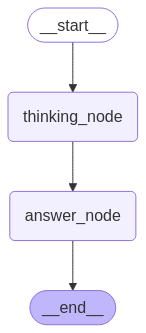

In [6]:
# define schemas for input and output
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

# this is schema for internal state
class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState) -> OverallState:
    # this is first node this input the input schema and update the 
    # overall state is updated by this node
    # node is updating his state
    print(state)
    return {"answer": "bye", "notes": "his name is Hansidu."}

def answer_node(state: OverallState) -> OutputState:
    print(state)
    return {"answer": "Bye Hansidu"}

# make the graph with input and output schemas
# schemas should provide at the when the state graph object creation 
graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

# compile the graph 
graph = graph.compile()

# view the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"question":"hi I am Hansidu"})

{'question': 'hi I am Hansidu'}
{'question': 'hi I am Hansidu', 'answer': 'bye', 'notes': 'his name is Hansidu.'}


{'answer': 'Bye Hansidu'}

## 3. State reducers

They specify how to perform updates.

We can use the Annotated type to specify a reducer function.

We just need a reducer that can perform this: operator.add is a function from Python's built-in operator module.

When operator.add is applied to lists, it performs list concatenation.

- operator.add function perform the list concatenation 

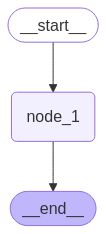

In [3]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

## 4. Custom Reducers

Lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be None.

In [4]:
def reduce_list(left: list | None, right: list | None) -> list:
    # safely combine two list whether the left or right list is none
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# state class with add operation
class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

# state class with custom reducer
class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

#### Below although it use initial state of none it works with custom reducer function

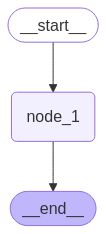

---Node 1---
{'foo': [2]}


In [5]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## 5. Filtering and trimming messages